<a href="https://colab.research.google.com/github/cu-applied-math/SciML-Class/blob/lab_solutions/Labs/lab02_gradientDescent_viaPyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2 solutions
Write a gradient descent code in PyTorch to minimize a least-squares objective

In [1]:
# https://pytorch.org/tutorials/beginner/examples_autograd/polynomial_custom_function.html
# also looking at https://pytorch.org/tutorials/beginner/introyt/autogradyt_tutorial.html
# and https://machinelearningmastery.com/implementing-gradient-descent-in-pytorch/ for simple way to do it

import torch
import matplotlib.pyplot as plt
# import matplotlib.ticker as ticker
# import math
import sys
import numpy as np
print("Torch version is", torch.__version__)
print("Numpy version is", np.__version__)
print("Python version is", sys.version)

Torch version is 2.4.0+cu121
Numpy version is 1.26.4
Python version is 3.10.12 (main, Jul 29 2024, 16:56:48) [GCC 11.4.0]


## Setup the function, and then experiment

In [18]:
n = int(1e3)
d = 500
G = torch.randn( (n,d) )  # requires_grad=False is implicit
Gtilde = torch.roll(G,1,dims=1)
A1 = G.detach()
A2 = G.detach() + (1-1e-7)*Gtilde.detach()
print(f'For problem 1, condition number is {torch.linalg.cond(A1).item():.2e}')
print(f'For problem 2, condition number is {torch.linalg.cond(A2).item():.2e}')
b = torch.randn( (n,1) )

def f1(x):
    return torch.linalg.norm( A1 @ x - b )**2

def f2(x):
    return torch.linalg.norm( A2 @ x - b )**2

def gradient_by_hand_prob1(x):
    return 2*A1.T @ (A1 @ x - b)

def gradient_by_hand_prob2(x):
    return 2*A2.T @ (A2 @ x - b)

For problem 1, condition number is 5.61e+00
For problem 2, condition number is 1.18e+07


#### Play around with things a bit
You can ignore this

In [ ]:
# x = torch.randn( d, requires_grad=True ) # Careful, the shape (d,) is incompatible with the shape (d,1) that we used above
x = torch.randn( (d,1) , requires_grad=True )

f(x), f(x.detach() )

(tensor(1005.5995, grad_fn=<PowBackward0>), tensor(1005.5995))

In [ ]:
x.grad.data.zero_()

out = f(x)
out.backward() # calls autodiff
# x.grad # and then we can request the gradient (with respect to x)
g1 = x.grad.numpy() # note that this is float32 (i.e., single, not double, precision!)

g2 = gradient_by_hand(x.detach() )
# g2 = gradient_by_hand(x) # works, but since we don't need gradient, good practice to detach first
# g2 = gradient_by_hand(x.numpy() ) # won't work, must detach first

with np.printoptions(precision=2, suppress=True):
    print(np.hstack((g1,g2)))


[[ 0.71  0.71]
 [ 3.59  3.59]
 [-1.59 -1.59]
 [-1.97 -1.97]
 [ 0.02  0.02]
 [-2.99 -2.99]
 [-0.3  -0.3 ]
 [-1.69 -1.69]
 [-0.01 -0.01]
 [-1.08 -1.08]
 [ 1.32  1.32]
 [-0.84 -0.84]
 [-2.69 -2.69]
 [-1.78 -1.78]
 [-1.6  -1.6 ]
 [-1.35 -1.35]
 [ 0.04  0.04]
 [ 2.44  2.44]
 [-1.33 -1.33]
 [-2.28 -2.28]]


## Try running gradient descent (written ourselves)

In [22]:
def gradient_descent(f, stepsize, maxits=1e3, printEvery=50, trueX=None):
  maxits = int(maxits)
  x = torch.zeros( (d,1) , requires_grad=True )  # d is a global variable for now
  # x.grad.data.zero_()
  lossHist = []
  errHist  = []
  if trueX is not None:
    error    = lambda x : torch.linalg.norm(x-trueX)
  else:
    error    = lambda x : 0

  for k in range(maxits):
    loss = f(x)
    lossHist.append( loss.item() )
    errHist.append( error(x.data) ) # both x and x.data work
    if k % printEvery == 0:
        print(f'Iteration {k+1:4d}, objective function is {loss.item():.2e}, error is {error(x.data):.2e}')

    loss.backward() # calls autodiff
    g = x.grad.data
    # alternatively:
    # g = gradient_by_hand(x.detach() ) # x.data or just x also work

    # take gradient descent step
    # x -= stepsize * g     # NO
    # x = x - stepsize * g  # NO.  After this, x.isleaf is false
    x.data = x.data - stepsize * g  # YES
    x.grad.data.zero_()
  return lossHist, errHist

In [23]:
# Try gradient descent
L1 = torch.linalg.norm(A1,ord=2)**2
L2 = torch.linalg.norm(A2,ord=2)**2

stepsize1 = .5/L1 # since we don't have the factor of 1/2 in objective, need that here!
stepsize2 = .5/L2

trueX1    = torch.linalg.lstsq(A1,b,rcond=None)[0]
trueX2    = torch.linalg.lstsq(A2,b,rcond=None)[0]

lossHist1, errHist1 = gradient_descent(f1, stepsize1, maxits=1e3, printEvery=50, trueX=trueX1)
lossHist2, errHist2 = gradient_descent(f2, stepsize2, maxits=1e3, printEvery=50, trueX=trueX2)




Iteration    1, objective function is 9.89e+02, error is 1.05e+00
Iteration   51, objective function is 4.41e+02, error is 7.05e-02
Iteration  101, objective function is 4.41e+02, error is 1.03e-02
Iteration  151, objective function is 4.41e+02, error is 1.70e-03
Iteration  201, objective function is 4.41e+02, error is 2.94e-04
Iteration  251, objective function is 4.41e+02, error is 5.27e-05
Iteration  301, objective function is 4.41e+02, error is 9.58e-06
Iteration  351, objective function is 4.41e+02, error is 1.85e-06
Iteration  401, objective function is 4.41e+02, error is 8.97e-07
Iteration  451, objective function is 4.41e+02, error is 8.39e-07
Iteration  501, objective function is 4.41e+02, error is 8.49e-07
Iteration  551, objective function is 4.41e+02, error is 8.63e-07
Iteration  601, objective function is 4.41e+02, error is 8.50e-07
Iteration  651, objective function is 4.41e+02, error is 8.48e-07
Iteration  701, objective function is 4.41e+02, error is 8.48e-07
Iteration 

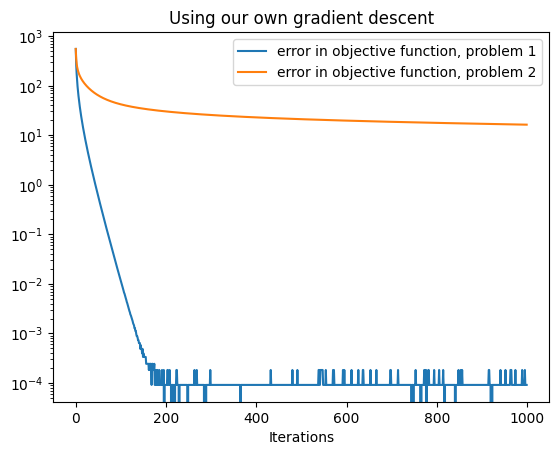

In [33]:
plt.semilogy( np.array(lossHist1) - f1(trueX1).item() , label='error in objective function, problem 1')
plt.semilogy( np.array(lossHist2) - f2(trueX2).item() , label='error in objective function, problem 2')
# plt.semilogy( errHist1, label='error in x, problem 1')
# plt.semilogy( errHist2, label='error in x, problem 2')
plt.xlabel('Iterations')
plt.legend()
plt.title('Using our own gradient descent')

import platform
hostname = platform.node()
plt.savefig(f'lab02_gradientDescent_{hostname}.pdf') # PDFs preferred over PNG since they embod fonts rather than rasterize them

plt.show()

## Try running one of the prebuilt optimizer classes in PyTorch

In [28]:
def gradient_descent_via_optimizer(f, stepsize, maxits=1e3, printEvery=50, trueX=None):
  maxits = int(maxits)
  x = torch.zeros( (d,1) , requires_grad=True )  # d is a global variable for now

  optimizer = torch.optim.SGD( [x], lr = stepsize )

  lossHist = []
  errHist  = []
  if trueX is not None:
    error    = lambda x : torch.linalg.norm(x-trueX)
  else:
    error    = lambda x : 0

  for k in range(maxits):
    optimizer.zero_grad()  # important!!

    loss = f(x)
    lossHist.append( loss.item() )
    errHist.append( error(x.data) ) # both x and x.data work
    if k % printEvery == 0:
        print(f'Iteration {k+1:4d}, objective function is {loss.item():.2e}, error is {error(x.data):.2e}')

    loss.backward()
    optimizer.step()  # this does the update on x for us

  return lossHist, errHist

In [29]:
lossHist1, errHist1 = gradient_descent_via_optimizer(f1, stepsize1, maxits=1e3, printEvery=50, trueX=trueX1)
lossHist2, errHist2 = gradient_descent_via_optimizer(f2, stepsize2, maxits=1e3, printEvery=50, trueX=trueX2)

Iteration    1, objective function is 9.89e+02, error is 1.05e+00
Iteration   51, objective function is 4.41e+02, error is 7.05e-02
Iteration  101, objective function is 4.41e+02, error is 1.03e-02
Iteration  151, objective function is 4.41e+02, error is 1.70e-03
Iteration  201, objective function is 4.41e+02, error is 2.94e-04
Iteration  251, objective function is 4.41e+02, error is 5.26e-05
Iteration  301, objective function is 4.41e+02, error is 9.58e-06
Iteration  351, objective function is 4.41e+02, error is 1.86e-06
Iteration  401, objective function is 4.41e+02, error is 9.19e-07
Iteration  451, objective function is 4.41e+02, error is 8.41e-07
Iteration  501, objective function is 4.41e+02, error is 8.46e-07
Iteration  551, objective function is 4.41e+02, error is 8.41e-07
Iteration  601, objective function is 4.41e+02, error is 8.45e-07
Iteration  651, objective function is 4.41e+02, error is 8.43e-07
Iteration  701, objective function is 4.41e+02, error is 8.59e-07
Iteration 

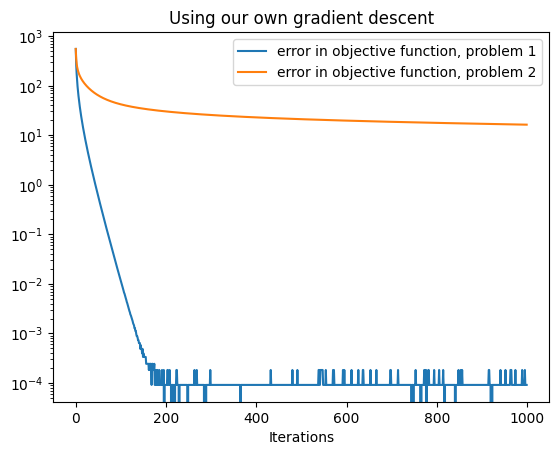

In [30]:
plt.semilogy( np.array(lossHist1) - f1(trueX1).item() , label='error in objective function, problem 1')
plt.semilogy( np.array(lossHist2) - f2(trueX2).item() , label='error in objective function, problem 2')
# plt.semilogy( errHist1, label='error in x, problem 1')
# plt.semilogy( errHist2, label='error in x, problem 2')
plt.xlabel('Iterations')
plt.legend()
plt.title('Using our own gradient descent')
plt.show()

### Variant: use LBFGS optimizer
Requires a slightly different format

In [32]:
x = torch.zeros( (d,1) , requires_grad=True )

f = f1
error = lambda x : torch.linalg.norm(x-trueX1)
stepsize = stepsize1*10 # be aggressive

optimizer = torch.optim.LBFGS( [x], lr = stepsize) # LBFGS needs a closure
lossHist = []
errHist  = []
printEvery = 50
maxits   = int(1e3)

for k in range(maxits):
    def closure():
        # LBFGS needs this; see https://stackoverflow.com/a/58059762
        loss = f(x)
        lossHist.append( loss.item() )
        errHist.append( error(x.data) ) # both x and x.data work
        if k % printEvery == 0:
            print(f'Iteration {k+1:4d}, objective function is {loss.item():.2e}, error is {error(x.data):.2e}')

        optimizer.zero_grad()
        loss.backward()
        return loss

    optimizer.step(closure)


plt.semilogy( np.array(lossHist) - f(trueX).item() , label='error in objective function')
plt.semilogy( errHist, label='error in x')
plt.xlabel('Iterations')
plt.legend()
plt.title('Using torch.optim.LBFGS')
plt.show()

Iteration    1, objective function is 9.89e+02, error is 1.05e+00
Iteration    1, objective function is 9.89e+02, error is 1.05e+00
Iteration    1, objective function is 9.87e+02, error is 1.04e+00
Iteration    1, objective function is 9.86e+02, error is 1.04e+00
Iteration    1, objective function is 9.84e+02, error is 1.04e+00
Iteration    1, objective function is 9.82e+02, error is 1.04e+00
Iteration    1, objective function is 9.80e+02, error is 1.04e+00
Iteration    1, objective function is 9.78e+02, error is 1.04e+00
Iteration    1, objective function is 9.77e+02, error is 1.04e+00
Iteration    1, objective function is 9.75e+02, error is 1.03e+00
Iteration    1, objective function is 9.73e+02, error is 1.03e+00
Iteration    1, objective function is 9.71e+02, error is 1.03e+00
Iteration    1, objective function is 9.69e+02, error is 1.03e+00
Iteration    1, objective function is 9.67e+02, error is 1.03e+00
Iteration    1, objective function is 9.66e+02, error is 1.03e+00
Iteration 

KeyboardInterrupt: 